In [1]:
import os
import copy
import time
import asyncio
import warnings
import logging

from pathlib import Path

import numpy as np
from astropy.io import fits

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
from astropy.modeling import models, fitting


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]

#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

%matplotlib inline

In [2]:
import wget

In [3]:
from lsst.ts import salobj
# from lsst.ts.standardscripts.auxtel.attcs import ATTCS
import asyncio

In [4]:
cam = salobj.Remote(salobj.Domain(), "GenericCamera", 1)

In [5]:
await cam.start_task

1579845024-tau02Hya_intra-0-1
1579845068-tau02Hya_extra-0-1
1579845024-tau02Hya_intra-0-1.fits
1579845068-tau02Hya_extra-0-1.fits
46 79
Creating stamps of centroid [y,x] = [408,608] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


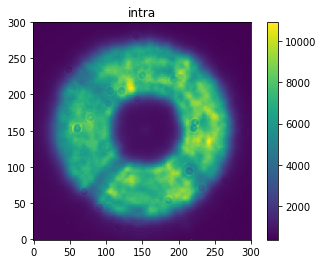

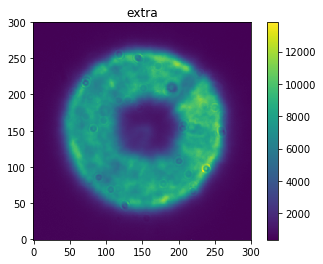

Extra-focal filename: 1579845068-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579845024-tau02Hya_intra-0-1.fits
[-207.04591778  -27.91694586    5.78538982   -1.47139725   54.36662899
  -35.94270422   25.7278528     1.52499364   -1.92470123    2.5442188
  -13.85584951   -7.45952758   11.21570711    3.13641663   -2.82123269
    0.69204595   -2.33039627   -1.8370957   -11.42057273]


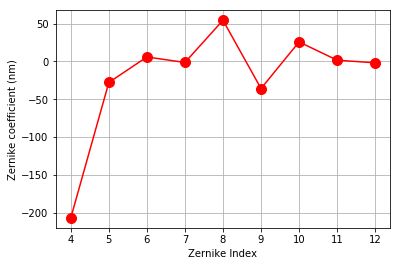

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 10 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 73 messages


In [7]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

1579845322-tau02Hya_intra-0-1
1579845363-tau02Hya_extra-0-1
1579845322-tau02Hya_intra-0-1.fits
1579845363-tau02Hya_extra-0-1.fits
8 11
Creating stamps of centroid [y,x] = [393,590] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


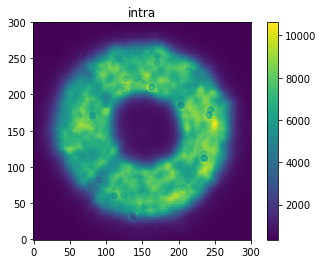

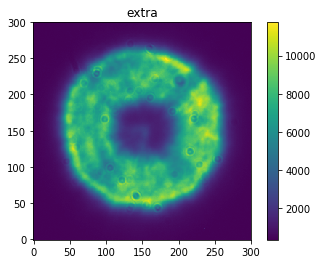

Extra-focal filename: 1579845363-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579845322-tau02Hya_intra-0-1.fits
[-185.9725607    97.34076044   32.92763425  -14.74824491   24.13414587
  -57.90200287   42.66401093    5.44521137   -0.64081208  -14.60805321
  -26.35406973  -28.73422967   13.40761907    0.47204802   -4.74769125
    8.5469113    -1.64849616  -10.30931271  -10.54414176]


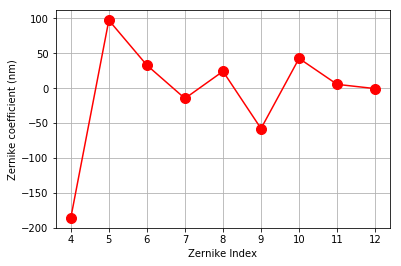

In [8]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 52 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 80 messages


1579845455-tau02Hya_intra-0-1
1579845499-tau02Hya_extra-0-1
1579845455-tau02Hya_intra-0-1.fits
1579845499-tau02Hya_extra-0-1.fits
5 8
Creating stamps of centroid [y,x] = [385,580] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


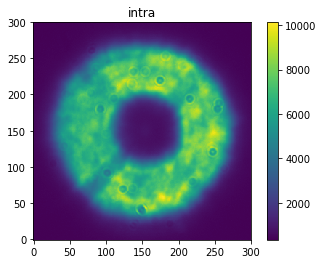

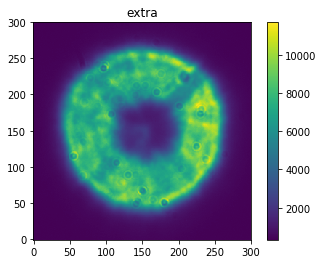

Extra-focal filename: 1579845499-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579845455-tau02Hya_intra-0-1.fits
[-147.33977671   13.2839942    43.12201262   -9.02930978   44.01578047
  -62.65027146   20.48136472   -5.61411389  -21.47650233   -7.74689861
  -18.20861532    9.13013528    9.94989219   -1.92802858    5.11678024
   -6.16899086   -7.3562065    -9.12436672   -6.6022363 ]


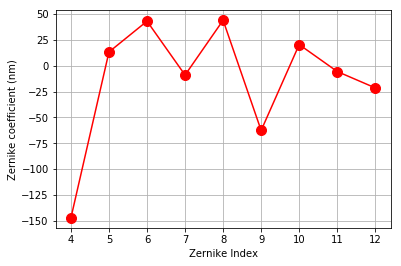

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 69 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 77 messages


In [9]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

1579845622-tau02Hya_intra-0-1
1579845667-tau02Hya_extra-0-1
1579845622-tau02Hya_intra-0-1.fits
1579845667-tau02Hya_extra-0-1.fits
18 48
Creating stamps of centroid [y,x] = [354,529] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


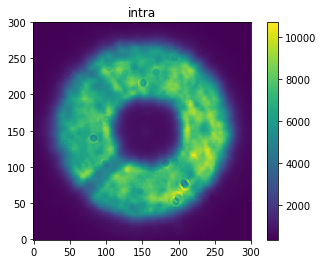

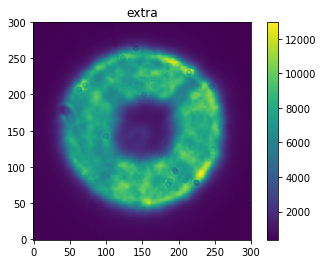

Extra-focal filename: 1579845667-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579845622-tau02Hya_intra-0-1.fits
[-171.12928021  -16.28075254  -42.36919818  -21.58141717   68.01169491
  -35.5668011     4.46638424   -4.95124422   21.53355495   -0.75577898
  -27.53090519    7.72994514    4.49136728    1.3413903    -2.24724841
    6.40856688   -4.09134903   13.40277953   -8.55025516]


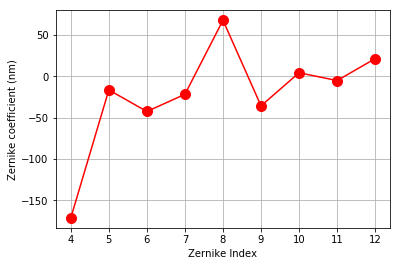

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 67 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 73 messages


In [10]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

1579845940-tau02Hya_intra-0-1
1579845984-tau02Hya_extra-0-1
1579845940-tau02Hya_intra-0-1.fits
1579845984-tau02Hya_extra-0-1.fits
118 178
Creating stamps of centroid [y,x] = [419,583] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


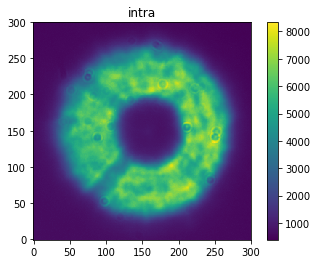

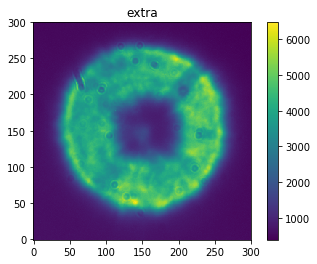

Extra-focal filename: 1579845984-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579845940-tau02Hya_intra-0-1.fits
[ 55.7771777   10.22903398  26.11144262 -32.76485293  32.09147607
 -70.14938313  83.78756684   9.98521454  -1.75454669 -11.49476646
 -19.59445719  -9.08246996  13.21468245   2.13977548  -8.4527033
   3.0772843    4.43993533   0.40465904 -12.39324695]


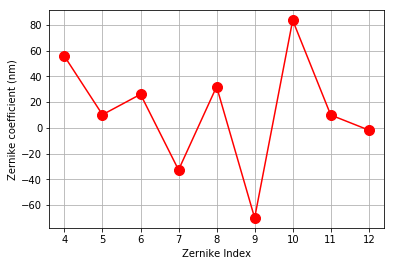

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 79 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 72 messages


In [11]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

1579846161-tau02Hya_intra-0-1
1579846201-tau02Hya_extra-0-1
1579846161-tau02Hya_intra-0-1.fits
1579846201-tau02Hya_extra-0-1.fits
104 135
Creating stamps of centroid [y,x] = [404,584] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


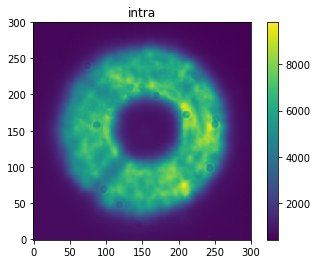

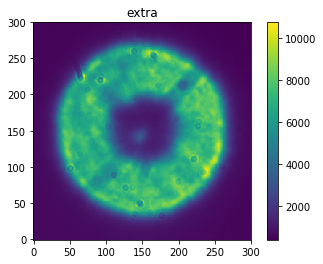

Extra-focal filename: 1579846201-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579846161-tau02Hya_intra-0-1.fits
[162.44308176 -10.55984518  -2.42926393 -55.19737276  34.04735599
  -3.79080511  23.11975166 -19.96597125   4.51220033  -8.77543791
  -0.76037892  -5.4123727   11.5013185   11.8265612   -8.95002321
   0.4862091    2.38983685   2.0967383   -6.41831574]


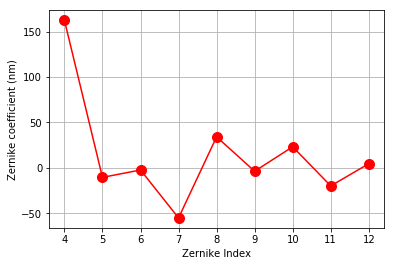

In [12]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 30 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 74 messages


1579846299-tau02Hya_intra-0-1
1579846343-tau02Hya_extra-0-1
1579846299-tau02Hya_intra-0-1.fits
1579846343-tau02Hya_extra-0-1.fits
99 109
Creating stamps of centroid [y,x] = [401,618] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


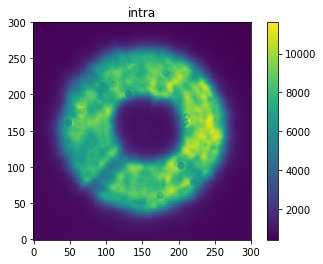

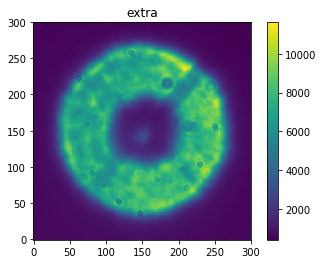

Extra-focal filename: 1579846343-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579846299-tau02Hya_intra-0-1.fits
[116.50550764 -20.89510339 -76.03450003 -32.96196962  64.53420213
 -31.35844164  19.59329859   1.00709717  13.09530299   1.926727
  -8.76321599   8.09997043   8.81848583  10.53391869  -6.02268366
   9.70236307   0.41541532  11.00117153  -9.33623025]


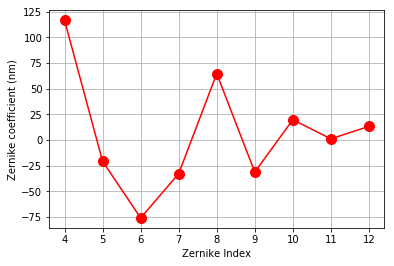

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 26 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 74 messages


In [13]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

1579846639-tau02Hya_intra-0-1
1579846683-tau02Hya_extra-0-1
1579846639-tau02Hya_intra-0-1.fits
1579846683-tau02Hya_extra-0-1.fits
125 76
Creating stamps of centroid [y,x] = [465,562] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


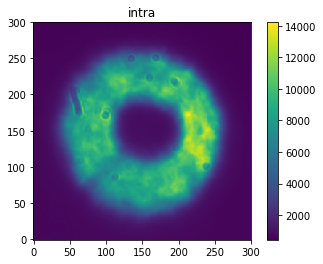

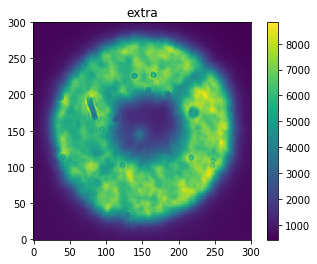

Extra-focal filename: 1579846683-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579846639-tau02Hya_intra-0-1.fits
[ 4.46042211e+02  7.89235320e+01 -7.07906756e+01 -5.41519992e+01
  4.99678029e+01 -2.38985404e+01  2.49526160e+01  2.20541827e+01
  3.31228105e+01 -4.99496074e+00 -2.65485420e+00 -1.91944536e+01
  1.14827552e+01  2.02693529e+01 -6.20137286e-01  4.11229199e-01
  2.85304400e+00  6.23972888e-01 -1.48782292e+01]


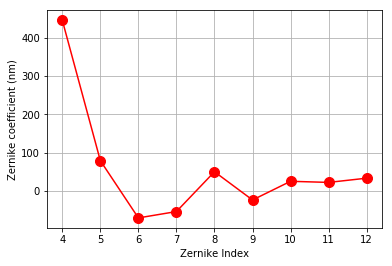

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 11 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 75 messages


1579846780-tau02Hya_intra-0-1
1579846824-tau02Hya_extra-0-1
1579846780-tau02Hya_intra-0-1.fits
1579846824-tau02Hya_extra-0-1.fits
114 64
Creating stamps of centroid [y,x] = [442,582] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


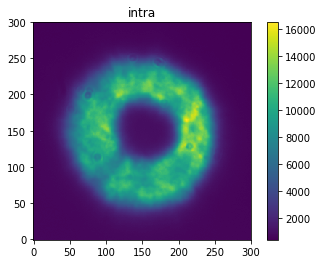

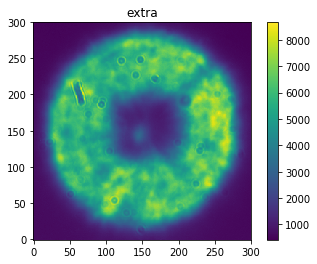

Extra-focal filename: 1579846824-tau02Hya_extra-0-1.fits
Intra-focal filename: 1579846780-tau02Hya_intra-0-1.fits
[822.1813633   91.77597049   7.72080382 -39.83595453  34.06119034
 -34.18938799  43.36246907  14.86412078  14.03299023  -3.8657699
  -9.54423625  -7.46173162  13.37323433  20.42840199   1.07333633
   6.30991579   1.51117095 -17.66834576 -13.61224709]


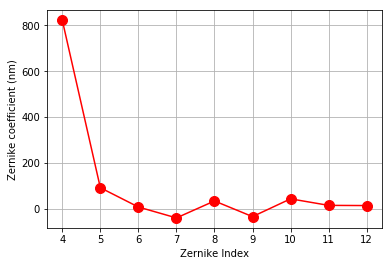

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 79 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 73 messages


In [15]:
for i in range(2):

    print(f"================================")
    cam.evt_endReadout.flush()

    intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(intra_endron.imageName)

    extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
    print(extra_endron.imageName)

    intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
    extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
    intra_fname = wget.download(intra_wget_url)
    print(f"============")
    print(f'{intra_fname}')
    extra_fname = wget.download(extra_wget_url)
    print(f'{extra_fname}')
    print(f"============")

    # Open fits files, note you can start here if your files exist already

    #intra_fname='I1_intra_20190908.fits'
    intra_exp=(fits.open(intra_fname))[0].data

    #extra_fname='I2_extra_20190908.fits'
    extra_exp=(fits.open(extra_fname))[0].data

    # Show images added together to estimate centroid
    plt.imshow(intra_exp+extra_exp)

    # Define the image it will use to perform final center
    im_shape=intra_exp.shape
    side=300
    # Set to False to declare centroid manually!
    if True:
        im= (intra_exp+extra_exp)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
    #     im_filtered[im_filtered < mean] = 0.
    #     im_filtered[im_filtered > mean] = 1.
        # iter 1
        ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        # iter 2
        intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
        extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
        im= (intra_square+extra_square)
        im_filtered = medfilt(im,[5,5])
        im_filtered -= int(np.median(im_filtered))
        mean = np.mean(im_filtered)
        im_filtered[im_filtered < mean] = 0.
        im_filtered[im_filtered > mean] = 1.
        # iter 1
        cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
        print(cy2-side, cx2-side)    
        ceny += (cy2-side)
        cenx += (cx2-side)
    else:
        # Manually declare where the center is
        ceny=350 #round(im_shape[0]/2)
        cenx=450 # round(im_shape[1]/2)
    side=150 # side length of image
    print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
    im_shape=intra_exp.shape
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

    #Create object for CWFS code
    # Select where your object is, but ours will be on-axis
    fieldXY = [0.0,0.0]

    # I1/I2 get modified down below, so reset here
    I1 = None; I2=None
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)

    # Declare instrument
    inst=Instrument('auxtel',I1.sizeinPix) # example
    hex_to_focus_scale = 41.0
    offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
    pixelsize = 3.6e-6*4 # 4 is the binning
    # FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

    print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
    print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
    print('pixelSize should be: {}'.format(pixelsize))

    #declare algorithm
    # declare algorithm - exponential solver.
    algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


    # Plot images
    plots.plotImage(I1.image,'intra') 
    #plots.plotImage(I_focus.image,'focus')
    plots.plotImage(I2.image,'extra')
    print('Extra-focal filename: {}'.format(extra_fname))
    print('Intra-focal filename: {}'.format(intra_fname))

    algo.runIt(inst,I1,I2,'onAxis')
    print(algo.zer4UpNm)
    plots.plotZer(algo.zer4UpNm[0:9],'nm')
    print(f"================================")

In [16]:

cam.evt_endReadout.flush()

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(intra_endron.imageName)

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=120)
print(extra_endron.imageName)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

1579847022-tau02Hya_intra-0-1
1579847067-tau02Hya_extra-0-1
1579847022-tau02Hya_intra-0-1.fits
1579847067-tau02Hya_extra-0-1.fits


TypeError: buffer is too small for requested array

In [20]:
intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")



1579847022-tau02Hya_intra-0-1 (1).fits
1579847067-tau02Hya_extra-0-1 (1).fits


In [21]:
#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data



75 51
Creating stamps of centroid [y,x] = [418,576] with a side length of 150 pixels
Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


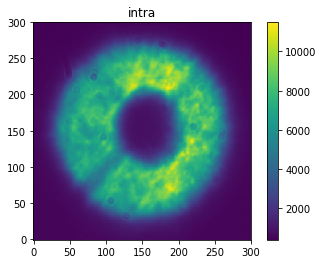

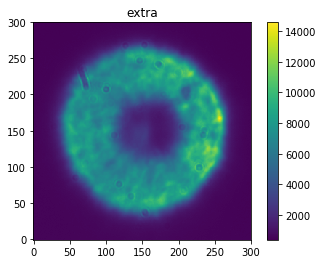

Extra-focal filename: 1579847067-tau02Hya_extra-0-1 (1).fits
Intra-focal filename: 1579847022-tau02Hya_intra-0-1 (1).fits
[-19.65231108 -33.26810839 106.58841783  16.28877341  29.58593485
 -75.26472889  37.78808474 -23.09667373 -26.63744379 -12.68026981
   9.92469497 -13.42587977  23.17551554  -2.32627723 -19.51637645
  -8.79886648   7.30575188   2.44357899 -11.06411224]


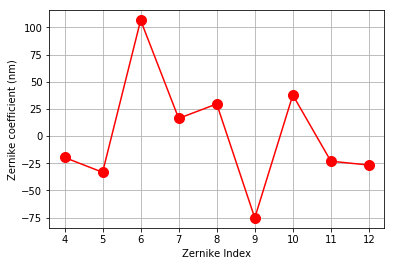

RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 75 messages


In [22]:
# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)


# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')